# Survival Models for Lung Cancer Prognosis

This notebook focuses on building and evaluating survival models to predict the survival duration of lung cancer patients based on their 3D CT scans and meta-data.

We will explore three different survival models:

- **Random Survival Forest (RSF)**.
- **Gradient Boosting (GB)**.
- **Survival Support Vector Machines (SVM)**.

The goal is to predict recurrence-free survival time. 

## Random Survival Forest.

It is an ensemble of ensemble of tree-based learners. Each individual trees are de-correlated by building each tree on a different bootstrap sample of the original training data and at each node, only evaluate the split criterion for a randomly selected subset of features and thresholds. Predictions are formed by aggregating predicitons of individuals and trees in the ensemble.

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

from sksurv.ensemble import RandomSurvivalForest

set_config(display="text")  # displays text representation of estimators

We load the data

In [5]:
# Load the dataset.
data = pd.read_csv("../data/meta_data.csv")

X = data.drop(['PatientID', 'SurvivalTime', 'Event'], axis=1)
y = np.array([tuple(row) for row in data[['Event', 'SurvivalTime']].values], dtype=[('cens', '?'), ('time', '<f8')])

Next the data is split into 75% for training and 25% for testing. So we can determine how well our model generalizes.

In [13]:
random_state = 20

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=random_state)

### Training

Several split-criterion have been proposed. The most widespread criterion is the one based on the log-rank test. 

In [9]:
rsf = RandomSurvivalForest(n_estimators=1000,
                           min_samples_split=10,
                           min_samples_leaf=15,
                           n_jobs=-1,
                           random_state=random_state)
rsf.fit(X_train, y_train)

RandomSurvivalForest(min_samples_leaf=15, min_samples_split=10,
                     n_estimators=1000, n_jobs=-1, random_state=20)

In [11]:
# Check how well the model performs on the test data.
rsf.score(X_test, y_test)

0.6931818181818182

A value of 0.69 is between a moderate and good discrimination.

### Predicting

For prediction, a sample is dropped in each tree in the forest until it reaches a terminal node. This data in each terminal is used to non-parametrically estimate the survival and cumulative hazard function using the Kaplan-Meier and Nelson-Aalen estimator, respectively. Furthermore, a risk score can be computed that represents the expected number of events for one particular terminal node. 

In [15]:
# Select patients according to size of the tumor and the age of the patient.
X_test_sorted = X_test.sort_values(by=['Voxel_Volume', 'age'])
X_test_sel = pd.concat((X_test_sorted.head(3), X_test_sorted.tail(3))) # Select 3 patients with smallest and 3 with largest tumor size.

X_test_sel

,Mstage,Nstage,Tstage,age,Histology_Adenocarcinoma,Histology_LargeCell,Histology_Nos,Histology_SquamousCellCarcinoma,Compactness_2,Maximum_Diameter,Sphericity,Surface_Volume_Area,Voxel_Volume
210,0,1,4,74.0808,0,1,0,0,0.649631,13.453624,0.866075,0.651869,640.0
15,0,0,3,77.0000,0,0,0,1,0.540955,16.763055,0.814805,0.660809,738.0
124,0,0,1,67.0000,1,0,0,0,0.511728,13.674794,0.799858,0.667874,756.0
58,0,0,2,78.0000,1,0,0,0,0.207591,98.392073,0.592111,0.143646,183955.0
150,0,2,3,71.2553,0,0,0,1,0.169012,105.919781,0.552891,0.136771,261684.0
102,0,0,4,56.8214,0,0,1,0,0.162281,155.438091,0.545451,0.130889,310977.0


The risk for the last three patients is quite a bit higher than that of the first three patients.

In [17]:
pd.Series(rsf.predict(X_test_sel))

0    32.984652
1    30.420022
2    18.272664
3    50.838800
4    69.856678
5    66.420277
dtype: float64

Let's consider the predicted survival function. Put it simply, the probability of surviving after a specific time t. By visualizing the plot, we can observe that the biggest difference occurs roughly within the 600 days.

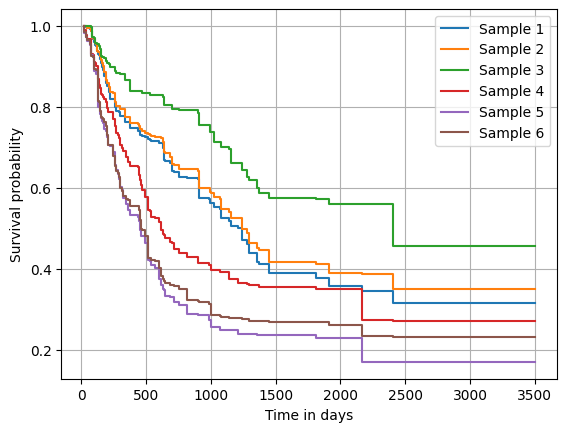

In [20]:
surv = rsf.predict_survival_function(X_test_sel, return_array=True)

for i, s in enumerate(surv):
    plt.step(rsf.unique_times_, s, where="post", label="Sample %d" % (i + 1))
plt.ylabel("Survival probability")
plt.xlabel("Time in days")
plt.legend()
plt.grid(True)

We can also predict the cumulative hazard function.

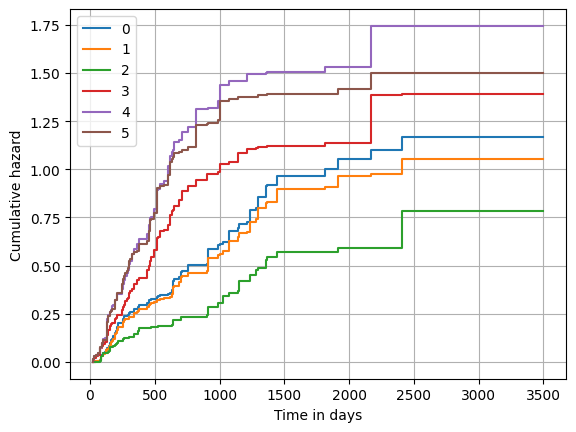

In [21]:
surv = rsf.predict_cumulative_hazard_function(X_test_sel, return_array=True)

for i, s in enumerate(surv):
    plt.step(rsf.unique_times_, s, where="post", label=str(i))
plt.ylabel("Cumulative hazard")
plt.xlabel("Time in days")
plt.legend()
plt.grid(True)

### Permutation-based Feature Importance

What's missing with the Random Forest is the importances of features. The way it defines 'importnace' is that it relies on the **impurity** for each child node, and defines the importance as the amount of decrease in impurity due to a split. However, for survival-analysis, there is no pre-node impurity measure due to censoring. Instead, we can use permutation to estimate feature importance, which is preferred.

In [25]:
result = permutation_importance(rsf, X_test, y_test, n_repeats=15, random_state=random_state)

pd.DataFrame(
    {
        k: result[k]
        for k in (
            "importances_mean",
            "importances_std",
        )
    },
    index=X_test.columns,
).sort_values(by="importances_mean", ascending=False)

,importances_mean,importances_std
Nstage,0.020412,0.018434
Surface_Volume_Area,0.016919,0.015324
age,0.014015,0.008085
Voxel_Volume,0.009049,0.009335
Tstage,0.001263,0.002557
Mstage,0.000000,0.000000
Histology_LargeCell,-0.000715,0.000858
Histology_SquamousCellCarcinoma,-0.000842,0.001965
Histology_Nos,-0.001094,0.000963
Maximum_Diameter,-0.005177,0.013550


Result shows that patients resulting at Nstage is by far the most important feature. Meaning that if it's relationship to survival time is removed (by random shuffling), the c-index on the test data drops by an average of 0.077655 points.

## Gradient Boosted Models